In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso  # scikit-learn
from numpy.lib.stride_tricks import sliding_window_view
from datetime import datetime

In [ ]:
# --- 1. System Parameters ---
N = 256
fc = 30e9
c = 3e8
lambda_c = c / fc
d = lambda_c / 2
D_aperture = (N - 1) * d
rayleigh_distance = (2 * D_aperture**2) / lambda_c
fresnel_distance = (D_aperture / 2) * ((D_aperture / lambda_c) ** (1/3))
print(f"rayleigh_distance is {rayleigh_distance}")
print(f"fresnel_distance is {fresnel_distance}")
# --- 2. Near-field modeling helpers (保持不变) ---

def near_field_manifold_doppler(Nt, d, f, r0, theta0_rad, v, phi_v, delta_t):
    c_ = 3e8
    nn = np.arange(-(Nt - 1) / 2, (Nt + 1) / 2)
    r = np.sqrt(r0**2 + (nn * d)**2 - 2 * r0 * nn * d * np.sin(theta0_rad))
    at = np.exp(-1j * 2 * np.pi * f * (r - r0) / c_) / np.sqrt(Nt)
    g = c_ / (f * 4 * np.pi * r0)
    phi = np.arctan2((nn * d - r0 * np.sin(theta0_rad)), (r0 * np.cos(theta0_rad)))
    vn = v * np.cos(phi_v - phi)
    doppler_term = 2 * np.pi * f * delta_t * vn / c_
    h = g * np.exp(-1j * 2 * np.pi * f * r0 / c_) * at * np.exp(-1j * doppler_term)
    return h, doppler_term


def dft_codebook(N):
    col = np.arange(-1 + 2/N, 1 + 2/N, 2/N)
    row = np.arange(-(N-1)/2, (N-1)/2+1).reshape(-1, 1)
    DFT = np.exp(1j * np.pi * row * col) / np.sqrt(N)
    codebook = []
    for k in range(N):
        codebook.append(DFT[:, k])
    return codebook


# --- 3. Create Near-Field Beam Codebook ---
range_min, range_max = 8, 80
dft_beam_codebook = dft_codebook(N)


rayleigh_distance is 325.12500000000006
fresnel_distance is 3.20860988672286


In [ ]:
# 多项式和GD函数

# ========== 工具函数 ==========
def theoretical_power(v, h_true):
    return float(np.abs(np.vdot(h_true, v))**2)

def observe_power(v, h, noise):
    y = np.vdot(v, h) + noise
    return np.abs(y ** 2)

def poly_eval(coeffs, t):
    # coeffs: [c0, c1, ..., c_poly]，返回 sum_{k=0..poly} coeffs[k] * t^k
    p = 0.0
    tk = 1.0
    for c in coeffs:
        p += c * tk
        tk *= t
    return p

def poly_eval_deriv(coeffs, x):
    """
    计算多项式在点 x 处的 *一阶导数* 的值。
    例如: coeffs = [c0, c1, c2, c3] (c0 + c1*x + c2*x^2 + c3*x^3)
    导数是: c1 + 2*c2*x + 3*c3*x^2
    """
    if len(coeffs) < 2:
        return 0.0
    # 导数多项式的系数: [c1, 2*c2, 3*c3, ...]
    deriv_coeffs = [i * coeffs[i] for i in range(1, len(coeffs))]
    
    # 计算这个新多项式在 x 处的值
    # 假设你已经有了 poly_eval 函数
    return poly_eval(deriv_coeffs, x)

# poly 形式写h_estimate
def h_estimate_at_t(t, alpha, beta, T_scale, delta_t, N, d, fc):

    # alpha, beta = unpack_w(w_vec, poly)
    theta_hat = float(poly_eval(alpha, t))
    r_hat = float(poly_eval(beta,  t))

    dr_dt_hat     = poly_eval_deriv(beta, t)
    dtheta_dt_hat = poly_eval_deriv(alpha, t)

    v_hat = np.sqrt(dr_dt_hat ** 2 + (r_hat * dtheta_dt_hat) ** 2)
    vx_hat = dr_dt_hat * np.cos(theta_hat) - r_hat * np.sin(theta_hat) * dtheta_dt_hat
    vy_hat = dr_dt_hat * np.sin(theta_hat) + r_hat * np.cos(theta_hat) * dtheta_dt_hat
    phi_v_hat = np.arctan2(vy_hat, vx_hat)

    h_hat_doppler, _ = near_field_manifold_doppler(N, d, fc, r_hat, theta_hat, v_hat, phi_v_hat, delta_t)
    
    return h_hat_doppler

# ======== close form ========
def single_sample_grad(alpha, beta, t, beam_vk, y_obs, delta_t, N, d, fc):
    kc1 = 2 * np.pi * fc / c
    kc2 = 2 * np.pi * fc * delta_t / c 

    # eq.1
    theta = poly_eval(alpha, t)
    r     = poly_eval(beta, t)
    dtheta = poly_eval_deriv(alpha, t)
    dr     = poly_eval_deriv(beta, t)

    nn = np.arange(-(N - 1) / 2, (N + 1) / 2)

    # 计算 Num偏导数的中间量
    # eq.8
    X_code = r * np.cos(theta)
    Y_code = nn * d - r * np.sin(theta)
    rn = np.sqrt(X_code ** 2 + Y_code ** 2) # n th antenna range to the ue

    # velocity 
    # eq. 9
    vx = dr * np.cos(theta) - r * dtheta * np.sin(theta)
    vy = dr * np.sin(theta) + r * dtheta * np.cos(theta)
    # eq. 11
    num_vn = vx * X_code + vy * Y_code
    vn = num_vn / rn

    # eq. 7
    phase_k = kc1 * rn + kc2 * vn
    # eq. 4
    g = c / (fc * 4 * np.pi * r)
    h_k = g * np.exp(-1j * phase_k) / np.sqrt(N)
    # eq. 3
    y_hat = np.vdot(beam_vk, h_k)
    res = y_hat - y_obs

    # ------- 底层偏导：∂r_n/∂χ, ∂v_n/∂χ  -------

    # r_n 对 r, θ
    # eq. 10
    drn_dr = (r - nn * d * np.sin(theta)) / rn
    drn_dtheta = -r * nn * d * np.cos(theta) / rn

    # vn 对 dr
    # eq. 12 & 13
    dvn_ddr = (r * np.cos(2 * theta) + nn * d * np.sin(theta)) / rn
    # vn 对 dtheta
    # eq. 12 & 14
    dvn_ddtheta = r * (nn * d * np.cos(theta) - r * np.sin(2 * theta)) / rn

    # vn 对 r
    # eq. 12 & 15
    dvx_dr = -dtheta * np.sin(theta)
    dvy_dr = dtheta * np.cos(theta)
    dnum_dr = dvx_dr * X_code + vx * np.cos(theta) + dvy_dr * Y_code - vy * np.sin(theta)
    dvn_dr = dnum_dr / rn - (vn / rn) * drn_dr
    # vn 对 theta
    # eq. 12 & 16
    dnum_dtheta = -vy * X_code - vx * r * np.sin(theta) + vx * Y_code - vy * r * np.cos(theta)
    dvn_dtheta = (dnum_dtheta  - vn * drn_dtheta) / rn

    # 对 Φ, 
    # eq. 7
    dPhi_dr = kc1 * drn_dr + kc2 * dvn_dr
    dPhi_dtheta = kc1 * drn_dtheta + kc2 * dvn_dtheta
    dPhi_ddr = kc2 * dvn_ddr
    dPhi_ddtheta = kc2 * dvn_ddtheta

    # eq. 6
    dh_dtheta = -1j * h_k * dPhi_dtheta
    dh_ddr = -1j * h_k * dPhi_ddr
    dh_ddtheta = -1j * h_k * dPhi_ddtheta
    # eq. 5
    dh_dr = h_k * (-1.0 / r - 1j * dPhi_dr)

    # eq. 3
    term_theta  = np.vdot(beam_vk, dh_dtheta)
    term_dr     = np.vdot(beam_vk, dh_ddr)
    term_dtheta = np.vdot(beam_vk, dh_ddtheta)
    term_r      = np.vdot(beam_vk, dh_dr)

    dJ_dtheta_k  = 2.0 * np.real(np.conj(res) * term_theta)
    dJ_ddr_k     = 2.0 * np.real(np.conj(res) * term_dr)
    dJ_ddtheta_k = 2.0 * np.real(np.conj(res) * term_dtheta)
    dJ_dr_k      = 2.0 * np.real(np.conj(res) * term_r)

    # 参数的次幂
    p_alpha = np.arange(len(alpha))
    p_beta  = np.arange(len(beta))

    # J 对 alpha的 导数
    # eq. 1
    t_pow_alpha = t ** p_alpha
    t_derive_alpha = np.zeros_like(p_alpha, dtype=float)
    t_derive_alpha[1:] = p_alpha[1:] * (t ** (p_alpha[1:] - 1))

    grad_alpha_k = dJ_dtheta_k * t_pow_alpha + dJ_ddtheta_k * t_derive_alpha

    # J 对 beta的 导数
    # eq. 2
    t_pow_beta = t ** p_beta
    t_der_beta = np.zeros_like(p_beta, dtype=float)
    t_der_beta[1:] = p_beta[1:] * (t ** (p_beta[1:] - 1))

    grad_beta_k = dJ_dr_k  * t_pow_beta + dJ_ddr_k * t_der_beta

    return grad_alpha_k, grad_beta_k   

def compute_gradients_matrix(alpha, beta, idxs, T, predict_beams, y_observe, delta_t, N, d, fc):
    """
    计算梯度，并返回：
    1. 梯度矩阵 (用于 Fisher Info 计算, 形状 [K, P])
    2. 平均梯度 (用于 Adam 更新)
    """
    k_list = list(idxs)
    K = len(k_list)
    p_alpha = len(alpha)
    p_beta = len(beta)
    
    # 预分配矩阵，避免 append
    G_alpha = np.zeros((K, p_alpha), dtype=float)
    G_beta  = np.zeros((K, p_beta),  dtype=float)
    
    # 只需要循环一次计算物理梯度
    for i, k in enumerate(k_list):
        t_k = T[k]
        v_k = predict_beams[k]
        y_k = y_observe[k]
        
        # 调用这一行最耗时的物理计算
        ga, gb = single_sample_grad(alpha, beta, t_k, v_k, y_k, delta_t, N, d, fc)
        
        # 存入矩阵
        G_alpha[i, :] = ga
        G_beta[i, :]  = gb
        
    # 计算 Adam 需要的平均梯度
    if K > 0:
        mean_grad_alpha = np.mean(G_alpha, axis=0)
        mean_grad_beta  = np.mean(G_beta, axis=0)
    else:
        mean_grad_alpha = np.zeros_like(alpha)
        mean_grad_beta  = np.zeros_like(beta)
        
    return G_alpha, G_beta, mean_grad_alpha, mean_grad_beta


def fisher_info_fast(G_alpha, G_beta, lambda_alpha, lambda_beta, sigma2):
    """
    利用矩阵乘法直接计算 Fisher Information Matrix
    F = scale * (G.T @ G) + Prior
    """
    K_eff = G_alpha.shape[0]
    
    # 1. 矩阵乘法代替 sum of outer products
    # (P, K) @ (K, P) -> (P, P)
    F_alpha = G_alpha.T @ G_alpha
    F_beta  = G_beta.T @ G_beta
    
    # 2. Scale
    if K_eff > 0 and sigma2 > 0:
        scale = 1.0 / (K_eff * (sigma2 ** 2))
        # scale = 1.0 / K_eff
        F_alpha *= scale
        F_beta  *= scale
        
    # 3. Add Prior (Regularization)
    # 加上对角阵
    p_alpha = G_alpha.shape[1]
    p_beta  = G_beta.shape[1]
    
    # F_alpha += 2 * lambda_alpha * np.eye(p_alpha)
    # F_beta  += 2 * lambda_beta  * np.eye(p_beta)
    
    return F_alpha, F_beta

def safe_inv_fisher(F, eps_rel, eps_abs):

    F = 0.5 * (F + F.T)
    
    eigvals, eigvecs = np.linalg.eigh(F)

    lam_max = float(np.max(eigvals))
    # 允许相对阈值 + 绝对阈值，防止全 0 时除零
    thresh = max(eps_abs, eps_rel * max(lam_max, 1.0))
    # thresh = 1e-16
    eigvals_clipped = np.clip(eigvals, thresh, None)  # 全部 >= thresh

    # F^{-1} = Q diag(1/λ_clipped) Q^T
    inv_eigvals = 1.0 / eigvals_clipped
    F_inv = eigvecs @ (inv_eigvals[:, None] * eigvecs.T)

    return F_inv

15.000000816603116 15.0
-0.785398099261587 -0.7853981633974483
[check] max Vx ≈ 0.490 m/s
[check] max speed ≈ 0.785 m/s


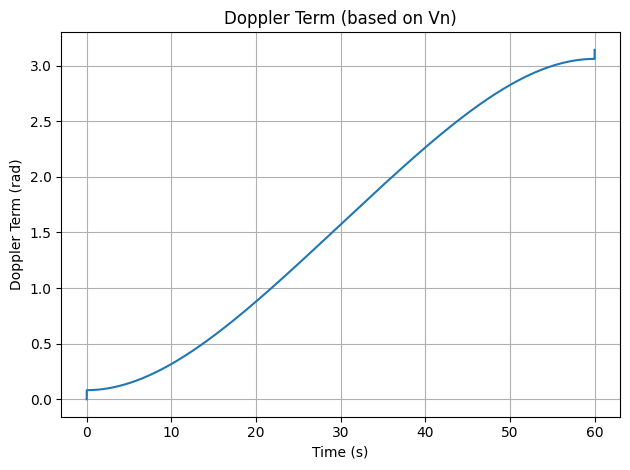

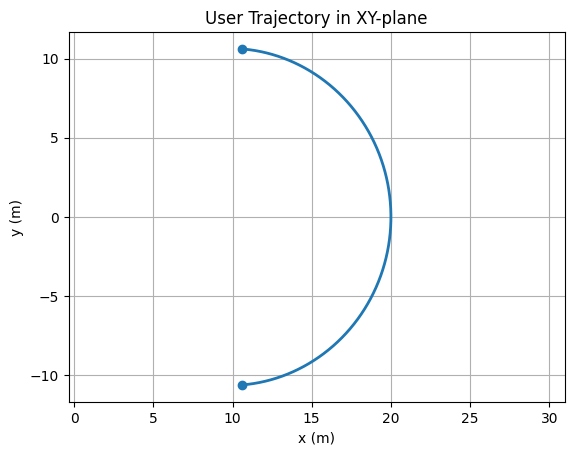

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin

# ========= 可调参数（速度微调主要靠扫角和 r 的量级） =========
t_start, t_end, dt = 0.0, 60.0, 2e-4
delta_t = 2e-4  # sweeping duration

theta_min = -0.7853981633974483   # -45°
theta_max = +0.7853981633974483   # +45°
theta_v   = 0.0                   # 抛物线顶点角度
r_v    =  20                      # 顶点半径（米）
r_edge =  15                      # 在 |θ|=45° 时的半径（米）
# r_v    =  60
# r_edge =  45
# ========= 时间 =========

T = np.arange(t_start, t_end + 1e-12, dt)  # 含端点
u = (T - T[0]) / (T[-1] - T[0]) 


# ========= 角度 =========
s = 3*u**2 - 2*u**3
theta = theta_min + (theta_max - theta_min) * s

# ========= 抛物线 r(θ) =========

a = (r_edge - r_v) / (theta_max - theta_v)**2
r = r_v + a * (theta - theta_v)**2

# ========= 区域限制 =========
theta = np.clip(theta, -pi/3, pi/3)
r     = np.clip(r, 8.0, 80.0)

print(r[35], r[0])
print(theta[35], theta[0])
# ========= 速度 =========
# v = sqrt( (dr/dt)^2 + (r * dθ/dt)^2 )
du_dt     = 1.0 / (t_end - t_start)
ds_dt     = (6*u - 6*u**2) * du_dt        
dtheta_dt = (theta_max - theta_min) * ds_dt
dr_dt     = 2 * a * (theta - theta_v) * dtheta_dt
V         = np.sqrt(dr_dt**2 + (r * dtheta_dt)**2)
Vx = dr_dt * np.cos(theta) - r * np.sin(theta) * dtheta_dt
Vy = dr_dt * np.sin(theta) + r * np.cos(theta) * dtheta_dt
Phi_v = np.arctan2(Vy, Vx)


print(f"[check] max Vx ≈ {float(np.max(Vx)):.3f} m/s")
# print(V[:128])
print(f"[check] max speed ≈ {float(np.max(V)):.3f} m/s")
H = np.zeros((len(T), N), dtype=complex)
doppler_term = np.zeros((len(T), N))
for i  in range(len(T)):
    r_now = r[i]
    theta_now = theta[i]
    v_now = V[i]
    # vx_now = Vx[i]

    h_now, doppler_now = near_field_manifold_doppler(N, d, fc, r_now, theta_now, v_now, Phi_v[i], delta_t)
    H[i, :] = h_now
    doppler_term[i, :] = -doppler_now

# plt.figure()
# plt.plot(T, Phi_v)
# plt.title("Doppler Term (based on Vn)")
# plt.xlabel('Time (s)')
# plt.ylabel('Doppler Term (rad)')
# plt.grid(True)
# plt.tight_layout()


# # ========= 画图 =========
# # 1) x-y 平面轨迹
# x = r * np.cos(theta)
# y = r * np.sin(theta)

# plt.figure()
# plt.plot(x, y, linewidth=2)
# plt.scatter([x[0], x[-1]], [y[0], y[-1]], marker='o')
# plt.axis('equal')
# plt.title("User Trajectory in XY-plane")
# plt.xlabel("x (m)")
# plt.ylabel("y (m)")
# plt.grid(True)
# plt.show()

In [ ]:

y_observe = []
predict_beams = []
used_beams = []
h_hat_lasso = None
poly_range = 6
poly_angle = 3
lambda_reg  = 5e-6
lambda_alpha = 5e-7
lambda_beta = 2e-5
eps_rel = 1
eps_abs = 1e-3
eta_alpha   = 1e-8      # 梯度下降学习率
eta_beta    = 1e-6
gd_steps    = 1000         # 每个gd内的内循环步数
L           = 500        # 只用最近 L 个观测做

warm_up_slots = 100
map_update_time = 2e-2
idle_time = 4e-2
sweeping_interval = 2e-4
map_interval = 2e-4
map_update_slot = int(map_update_time / map_interval) #100
idle_slot = int(idle_time / sweeping_interval) 
cycle_slot_total = map_update_slot + idle_slot 
map_sampling_stride = 1
step = 1

TH_MIN, TH_MAX = -np.pi/3, np.pi/3
R_MIN,  R_MAX  = 8.0, 80.0

# 指标，normlized gain & trace
baseline_gain = []       # baseline
measured_gain = []       # 每measured, 用的是map估计的beam打的
no_tracking_gain = []
idle_gain = []     
est_theta_list = []      # 每时隙的估计 θ_hat(t_i)
est_r_list = []          # 每时隙的估计 r_hat(t_i)

# 新增：把 measured gain 按 batch / idle 分类保存
measured_gain_batch = []   # 只在 batch 时刻非 NaN
measured_gain_idle  = []   # 只在 idle（含 warm-up）非 NaN
# 新增：记录“当前 slot 用的 beam”属于 batch 还是 idle
phase_list = []            # 每一根 predict_beam 对应一个 phase: 'batch' 或 'idle'

# 高斯扰动的方差
delta_theta = 1e-9
delta_r     = 5e-8

P_TX = 1
SNR_dB = 20
SNR_linear = 10**(SNR_dB / 10.0)

# # 归一化 t
# u_arr = (T - T[0]) / (T[-1] - T[0])         # ∈[0,1]
T_scale = 1.0 / (t_end - t_start)
tune_alpha = 1e-3
tune_beta = 1e-4
# w_map = np.full(2*(poly+1), 1e-9, dtype=float)  # 联合参数向量的先验均值，对应单位协方差

# alpha_map = np.array([-0.7853981633974483, 0])
# beta_map = np.array([15, 0, 1e-2])
alpha_map = np.array([-0.7853981633974483, 0, 1e-3, 1e-5])
beta_map = np.array([15, 0, 1e-2, 1e-4, 1e-5, 1e-6, 1e-9])

output_dir = "first exploitation longer idle debug OLD"
os.makedirs(output_dir, exist_ok=True)
print(f"输出目录 '{output_dir}' 已确保存在。")

init_h = h_estimate_at_t(T[0], alpha_map, beta_map, T_scale, delta_t, N, d, fc)
P_signal = P_TX * np.mean(np.abs(init_h)**2)
sigma2 = P_signal / SNR_linear
print(sigma2)
init_h = init_h / np.linalg.norm(init_h)
predict_beams.append(init_h)
phase_list.append('idle')   # 初始 beam 视为 idle 类别
valid_map_indices = []

tracking_points = 20000
T_obs = T[:tracking_points:step]
r_obs = r[:tracking_points:step]
theta_obs = theta[:tracking_points:step]
H_obs = H[:tracking_points:step, :]
V_obs = V[:tracking_points:step] # 同样对 V 进行切片，用于预热阶段
Phi_v_obs = Phi_v[:tracking_points:step]
map_update_count = 0

输出目录 'first exploitation longer idle debug OLD' 已确保存在。
1.0994052044524501e-13


In [ ]:

for slot_idx, (t_i, r_i, theta_i, h_true, v_true, phi_v_true) in enumerate(zip(T_obs, r_obs, theta_obs, H_obs, V_obs, Phi_v_obs), start=0):
    
    # Basic Setting
    norm_h_true = h_true / np.linalg.norm(h_true)

    noise_std = np.sqrt(sigma2/2.0)
    rng = np.random.default_rng(slot_idx)
    noise = rng.normal(0.0, noise_std) + 1j*rng.normal(0.0, noise_std)

    # baseline
    baseline_gain.append(theoretical_power(norm_h_true, norm_h_true))
    no_tracking_gain.append(theoretical_power(init_h, norm_h_true))
    v = predict_beams[slot_idx]
    y = np.vdot(v, h_true) + noise

    y_observe.append(y)
    used_beams.append(v)


    current_gain = theoretical_power(v, norm_h_true)
    measured_gain.append(current_gain)
    print(current_gain)
    
    # 新增：根据当前 slot 使用的 beam 类型（batch / idle）分类增益
    # phase_list[slot_idx] 是上一轮为本 slot 准备 beam 时记录的类型
    phase_current = phase_list[slot_idx] if slot_idx < len(phase_list) else 'idle'
    if phase_current == 'batch':
        measured_gain_batch.append(current_gain)
        measured_gain_idle.append(np.nan)
    else:
        # idle（含 warmup）
        measured_gain_idle.append(current_gain)
        measured_gain_batch.append(np.nan)

    if len(y_observe) <= warm_up_slots:
        # --- WARM-UP ---
        theta_true_now = theta_i      # 使用当前真实 theta
        r_true_now = r_i              # 使用当前真实 r
        v_true_now = v_true    # 使用当前真实 v
        phi_v = phi_v_true      # 使用当前真实的 phi

        th_tilde = float(theta_true_now + rng.normal(0.0, delta_theta))
        r_tilde  = float(r_true_now + rng.normal(0.0, delta_r))
        r_tilde  = np.clip(r_tilde, R_MIN, R_MAX)

        h_explore, _ = near_field_manifold_doppler(N, d, fc,
                                                 r_tilde, th_tilde,
                                                 v_true_now, phi_v, delta_t) 
        

        v_next_tx = h_explore / (np.linalg.norm(h_explore) + 1e-12)
        est_theta_list.append(th_tilde)
        est_r_list.append(r_tilde)
        valid_map_indices.append(len(y_observe) - 1)
        predict_beams.append(v_next_tx)
        phase_list.append('idle')

    else:
        # --- MAP 跟踪阶段 ---
        current_idx = len(y_observe) - 1
        rel_idx = current_idx - warm_up_slots
        pos_in_cycle = rel_idx % cycle_slot_total
        if pos_in_cycle < map_update_slot:
            valid_map_indices.append(current_idx)
        # Case 1: 刚结束预热的第一帧 (rel_idx=0)
        is_map_update_time = False
        if rel_idx == 0:
            is_map_update_time = True
        
        # Case 2: 周期性检查
        # 当 pos_in_cycle 刚好等于 map_update_slot 时，说明前一帧是Active的最后一帧
        elif pos_in_cycle == map_update_slot:
            is_map_update_time = True
                      
        if is_map_update_time:
            print(f"--- Slot {slot_idx} (t={t_i:.4f}s): 运行 MAP-GD 优化 (L={L}) ---")

            if len(valid_map_indices) >= L:
                idxs = valid_map_indices[-L:]
            else:
                idxs = valid_map_indices[:] # 数据不够 L 时全用
            eps = 1e-6

            # Adam算法的超参数
            adam_lr_alpha = 1e-9
            adam_lr_beta = 1e-7
            beta1 = 0.9       # 动量衰减率 (标准值)
            beta2 = 0.999     # RMSProp 衰减率 (标准值)
            epsilon = 1e-20    # 避免除零 (标准值)
            eps_alpha = 5e-7
            eps_beta = 1e-6

            m_alpha = np.zeros_like(alpha_map)
            v_alpha = np.zeros_like(alpha_map)
            m_beta  = np.zeros_like(beta_map)
            v_beta  = np.zeros_like(beta_map)
            step_count = 0

            traj_alpha = [alpha_map.copy()]
            traj_beta  = [beta_map.copy()]

            for i in range(gd_steps):
                # Adam 的时间步 t，用于偏差修正（从1开始）
                t_adam = i + 1

                # 1. 计算梯度 (保持不变)
                G_alpha, G_beta, g_alpha, g_beta = compute_gradients_matrix(alpha_map, beta_map, idxs, T, used_beams, y_observe, delta_t, N, d, fc)

                # g_alpha, g_beta = compute_gradients(alpha_map, beta_map, lambda_alpha, lambda_beta, idxs, T, used_beams, y_observe, delta_t, N, d,fc)
                # 2. Adam 更新 Alpha
                m_alpha = beta1 * m_alpha + (1 - beta1) * g_alpha
                v_alpha = beta2 * v_alpha + (1 - beta2) * (g_alpha**2)
                m_hat_alpha = m_alpha / (1 - beta1**t_adam)
                v_hat_alpha = v_alpha / (1 - beta2**t_adam)
                alpha_map = alpha_map - adam_lr_alpha * m_hat_alpha / (np.sqrt(v_hat_alpha) + epsilon)
                # 3. Adam 更新 Beta
                m_beta = beta1 * m_beta + (1 - beta1) * g_beta
                v_beta = beta2 * v_beta + (1 - beta2) * (g_beta**2)
                m_hat_beta = m_beta / (1 - beta1**t_adam)
                v_hat_beta = v_beta / (1 - beta2**t_adam)
                beta_map = beta_map - adam_lr_beta * m_hat_beta / (np.sqrt(v_hat_beta) + epsilon)

            F_alpha, F_beta = fisher_info_fast(G_alpha, G_beta, lambda_alpha, lambda_beta, sigma2)
            # cov_alpha = np.linalg.inv(F_alpha)
            # cov_beta = np.linalg.inv(F_beta)
            cov_alpha = safe_inv_fisher(F_alpha, eps_rel, eps_abs)
            cov_beta = safe_inv_fisher(F_beta, eps_rel, eps_abs)
            # cov_alpha *= sigma2 ** 2
            # cov_beta *= sigma2 ** 2
            map_update_count += 1
            print(cov_alpha)
            print(cov_beta)
        # 结束Adam
        # ========== 根据本轮优化后的w，取θ和r ===========

        theta_hat_i = float(poly_eval(alpha_map, t_i))
        r_hat_i     = float(poly_eval(beta_map,  t_i))
        est_theta_list.append(theta_hat_i)
        est_r_list.append(r_hat_i)

        # ========== 用更新后的 w_map 选择“下一次要打的 beam” ==========
        next_idx = len(y_observe)          # 当前已经 append 了本 slot 的观测，所以下一次是这个 index
        rel_idx_next = next_idx - warm_up_slots
        pos_in_cycle_next = rel_idx_next % cycle_slot_total
        if slot_idx + 1 < len(T_obs):
            t_next = float(T_obs[slot_idx + 1])
        else:
            t_next = float(T_obs[slot_idx])
        if pos_in_cycle_next >= map_update_slot or (map_update_count == 0):
            # -------- idle 段：用最近一次 MAP 的均值 α_map, β_map 生成 beam（不采样） --------
            h_next_tx = h_estimate_at_t(t_next, alpha_map, beta_map,
                                        T_scale, delta_t, N, d, fc)
            phase_next = 'idle'
        else:
            # -------- MAP interval 段：用 Fisher 信息采样得到的 α, β 生成 beam --------
            alpha_sample = rng.multivariate_normal(alpha_map, cov_alpha)
            beta_sample  = rng.multivariate_normal(beta_map,  cov_beta)

            h_next_tx = h_estimate_at_t(t_next, alpha_sample, beta_sample, T_scale, delta_t, N, d, fc)
            phase_next = 'batch'
        v_next_tx = h_next_tx / (np.linalg.norm(h_next_tx))

        predict_beams.append(v_next_tx) 
        phase_list.append(phase_next)

# ========== 图1：Normalized Gain (All Measured) ==========
plt.figure()
plt.plot(T_obs, baseline_gain, label="Baseline (True)", linewidth=2)
plt.plot(T_obs, measured_gain, label="Measured (All)", linewidth=2)
plt.plot(T_obs, no_tracking_gain, label="No-Tracking (init_h beam)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Gain")
plt.title("Normalized Gain vs Time (All Measured)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "Normalized_gain_all.png"), dpi=600, bbox_inches='tight')

# ========== 图2：Normalized Gain (Batch Only) ==========
plt.figure()
plt.plot(T_obs, baseline_gain, label="Baseline (True)", linewidth=2)
plt.plot(T_obs, measured_gain_batch, label="Measured (Batch Interval)", linewidth=2)
plt.plot(T_obs, no_tracking_gain, label="No-Tracking (init_h beam)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Gain")
plt.title("Normalized Gain vs Time (Batch Intervals)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "Normalized_gain_batch.png"), dpi=600, bbox_inches='tight')

# ========== 图3：Normalized Gain (Idle + Warm-up Only) ==========
plt.figure()
plt.plot(T_obs, baseline_gain, label="Baseline (True)", linewidth=2)
plt.plot(T_obs, measured_gain_idle, label="Measured (Idle/Warm-up)", linewidth=2)
plt.plot(T_obs, no_tracking_gain, label="No-Tracking (init_h beam)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Gain")
plt.title("Normalized Gain vs Time (Idle + Warm-up)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "Normalized_gain_idle.png"), dpi=600, bbox_inches='tight')

# ========== 图4：轨迹（真实 vs 估计）==========
x_true = r_obs * np.cos(theta_obs)
y_true = r_obs * np.sin(theta_obs)
# T_map = T_obs # <--- T_map 未被使用
x_est = np.array(est_r_list) * np.cos(np.array(est_theta_list))
y_est = np.array(est_r_list) * np.sin(np.array(est_theta_list))
plt.figure()
plt.plot(x_true, y_true, label="True Trajectory", linewidth=2)
plt.plot(x_est,  y_est,  label="Estimated Trajectory (from α,β)", linewidth=2)
plt.scatter([x_true[0]], [y_true[0]], marker='o', label="Start (True)")
plt.axis('equal')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("User Trajectory: True vs Estimated")
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig(os.path.join(output_dir, "trajectory_detailed.png"), dpi=600, bbox_inches='tight')

# ========== 图5：Normalized Gain (Batch + Idle Curves) ==========
plt.figure()
plt.plot(T_obs, baseline_gain, label="Baseline (True)", linewidth=2)
plt.plot(T_obs, measured_gain_batch, label="Measured (Batch Interval)", linewidth=2)
plt.plot(T_obs, measured_gain_idle, label="Measured (Idle/Warm-up)", linewidth=2)
plt.plot(T_obs, no_tracking_gain, label="No-Tracking (init_h beam)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Gain")
plt.title("Normalized Gain vs Time (Batch + Idle)")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "Normalized_gain_batch_idle.png"), dpi=600, bbox_inches='tight')

# *** 新增：保存所有数据到 CSV 文件 ***
print("正在保存数据到 CSV...")
baseline_gain_data      = np.array(baseline_gain)
measured_gain_data      = np.array(measured_gain)
no_tracking_gain_data   = np.array(no_tracking_gain)
batch_gain_data         = np.array(measured_gain_batch)
idle_gain_data          = np.array(measured_gain_idle)

df_data = pd.DataFrame({
    'Time': T_obs,
    'True_Theta': theta_obs,
    'True_R': r_obs,
    'True_X': x_true,
    'True_Y': y_true,
    'Est_Theta': np.array(est_theta_list),
    'Est_R': np.array(est_r_list),
    'Est_X': x_est,
    'Est_Y': y_est,
    'Baseline_Gain': baseline_gain_data,
    'Measured_Gain': measured_gain_data,
    'NoTracking_Gain': no_tracking_gain_data,
    'Measured_Gain_Batch': batch_gain_data,
    'Measured_Gain_Idle': idle_gain_data
})

output_path = os.path.join(output_dir, "tracking_results.csv")
df_data.to_csv(output_path, index=False)
print(f"所有跟踪数据已保存到: {output_path}")

0.9999999999999996
0.9999999623008827
0.9999999623008892
0.9999999623008736
0.9999999623008894
0.9999999623008559
0.9999999623008663
0.9999999623005914
0.9999999623008534
0.9999999623007415
0.9999999623006862
0.9999999623007841
0.9999999623008887
0.9999999623008767
0.999999962300881
0.9999999623006172
0.9999999623008416
0.9999999623008721
0.9999999623007255
0.9999999623008392
0.9999999623008101
0.9999999623008701
0.9999999623004284
0.9999999623005099
0.9999999623007058
0.9999999623004961
0.9999999623005976
0.9999999623008083
0.9999999623007801
0.9999999623005938
0.9999999623005856
0.9999999623004004
0.9999999623006796
0.9999999623005534
0.9999999623006431
0.9999999623008528
0.9999999623006969
0.9999999623004178
0.9999999623001207
0.9999999623004862
0.9999999623004473
0.9999999623001888
0.9999999623003549
0.999999962300499
0.99999996230015
0.9999999623003587
0.9999999623002854
0.9999999623001478
0.9999999622995809
0.9999999623002175
0.9999999623002035
0.999999962300289
0.999999962300097